# Simulations light inter

In [23]:
from __future__ import annotations

import sys
import time as t

# sys.path.append(r'd:\ArchiCrop\tutorials') 
import matplotlib.pyplot as plt
import oawidgets.mtg
import pandas as pd
from alinea.caribu.data_samples import data_path
from archi_dict import archi
from oawidgets.plantgl import *

from openalea.archicrop.archicrop import ArchiCrop
from openalea.archicrop.display import build_scene, display_scene
from openalea.archicrop.light_it import illuminate, mean_leaf_irradiance
from openalea.archicrop.simulation import (
    LHS_param_sampling,
    params_for_curve_fit,
    plot_constrainted_vs_realized,
    simulate_fit_params,
    stics_weather_3d,
)
from openalea.archicrop.sky_sources import meteo_day
from openalea.archicrop.stics_io import get_stics_data
from openalea.astk.sky_irradiance import sky_irradiance
from openalea.astk.sky_sources import caribu_light_sources, sky_sources
from openalea.plantgl.all import Color3, Material, Scene

%gui qt

In [ ]:
# stics_color
# archicrop_color

In [24]:
# Retrieve STICS management and senescence parameters
sowing_density, daily_dynamics, lifespan, lifespan_early = get_stics_data(
    file_tec_xml='sorgho_tec.xml',  # Path to the STICS management XML file
    file_plt_xml='corn_plt.xml',  # Path to the STICS plant XML file
    stics_output_file='mod_smaize_in_sorg_cond.sti'  # Path to the STICS output file
)
inter_row = 70 # cm

# Retrieve STICS growth and senescence dynamics
thermal_time = [value["Thermal time"] for value in daily_dynamics.values()]
leaf_area_plant = [value["Plant leaf area"] for value in daily_dynamics.values()]
sen_leaf_area_plant = [value["Plant senescent leaf area"] for value in daily_dynamics.values()]
height_canopy = [value["Plant height"] for value in daily_dynamics.values()]
par_incident = [value["Incident PAR"] for value in daily_dynamics.values()]
par_stics = [value["Absorbed PAR"] for value in daily_dynamics.values()]

In [45]:
archi["height"] = [1.1*max(height_canopy), 5*max(height_canopy)]
archi["leaf_area"] = [1.1*max(leaf_area_plant), 5*max(leaf_area_plant)]
archi["leaf_lifespan"] = [lifespan_early, lifespan]

In [46]:
# Function to process parameters and generate samples
# Generate parameter sets
param_sets = LHS_param_sampling(archi, daily_dynamics, n_samples=200000, seed=42)
print(len(param_sets))

14319


In [47]:
# Select parameters sets for which the model fits the LAI and the height curves of the crop model, with a given error.

# Start the timer
start_time = t.time()

fit_params, non_fit_params, pot_la, pot_h = params_for_curve_fit(param_sets, curves=daily_dynamics, error_LA=0.05, error_height=0.05)

# End the timer
end_time = t.time()

# Calculate elapsed time
elapsed_time = (end_time - start_time)/60
print(f"Elapsed time: {elapsed_time:.4f} minutes")

Elapsed time: 5.1675 minutes


In [48]:
print(len(fit_params))

14


In [49]:
fit_params

[{'diam_base': 2.5,
  'diam_top': 1.5,
  'skew': 0.005,
  'klig': 0.6,
  'swmax': 0.55,
  'f1': 0.64,
  'f2': 0.92,
  'insertion_angle': 35,
  'scurv': 0.7,
  'curvature': 120,
  'phyllotactic_angle': 137.5,
  'phyllotactic_deviation': 0,
  'nb_tillers': 0,
  'tiller_delay': 1,
  'tiller_angle': 30,
  'reduction_factor': 1,
  'plant_orientation': 0,
  'leaf_lifespan': [200.0, 200.0],
  'nb_phy': 16,
  'nb_short_phy': 3,
  'short_phy_height': 3.828563196134337,
  'stem_q': 1.0242213351491434,
  'rmax': 0.7120885896692427,
  'wl': 0.12893653289064536,
  'phyllochron': 31.00808116263367,
  'plastochron': 39.425314688820606,
  'height': 671.0765492008569,
  'leaf_area': 5187.517990773152},
 {'diam_base': 2.5,
  'diam_top': 1.5,
  'skew': 0.005,
  'klig': 0.6,
  'swmax': 0.55,
  'f1': 0.64,
  'f2': 0.92,
  'insertion_angle': 35,
  'scurv': 0.7,
  'curvature': 120,
  'phyllotactic_angle': 137.5,
  'phyllotactic_deviation': 0,
  'nb_tillers': 0,
  'tiller_delay': 1,
  'tiller_angle': 30,
  'r

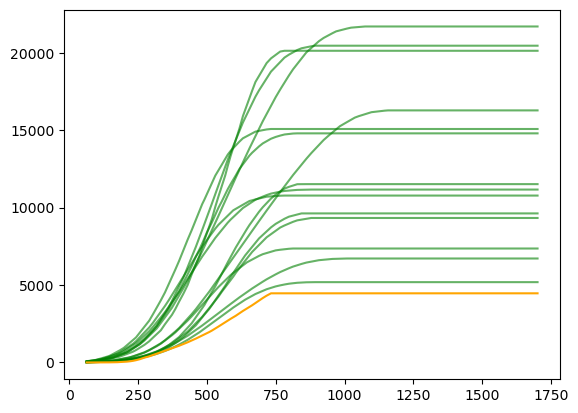

In [50]:
for la in pot_la:
    plt.plot(thermal_time, la, color="green", alpha=0.6)
plt.plot(thermal_time, leaf_area_plant, color="orange")
plt.show()

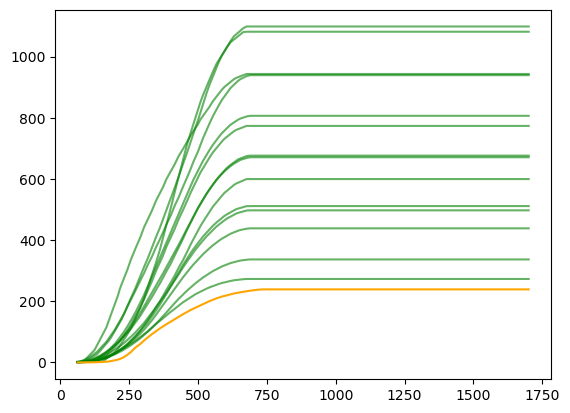

In [51]:
for h in pot_h:
    plt.plot(thermal_time, h, color="green", alpha=0.6)
plt.plot(thermal_time, height_canopy, color="orange")
plt.show()

In [52]:
LA_archicrop, height_archicrop, mtgs = simulate_fit_params(fit_params, daily_dynamics)

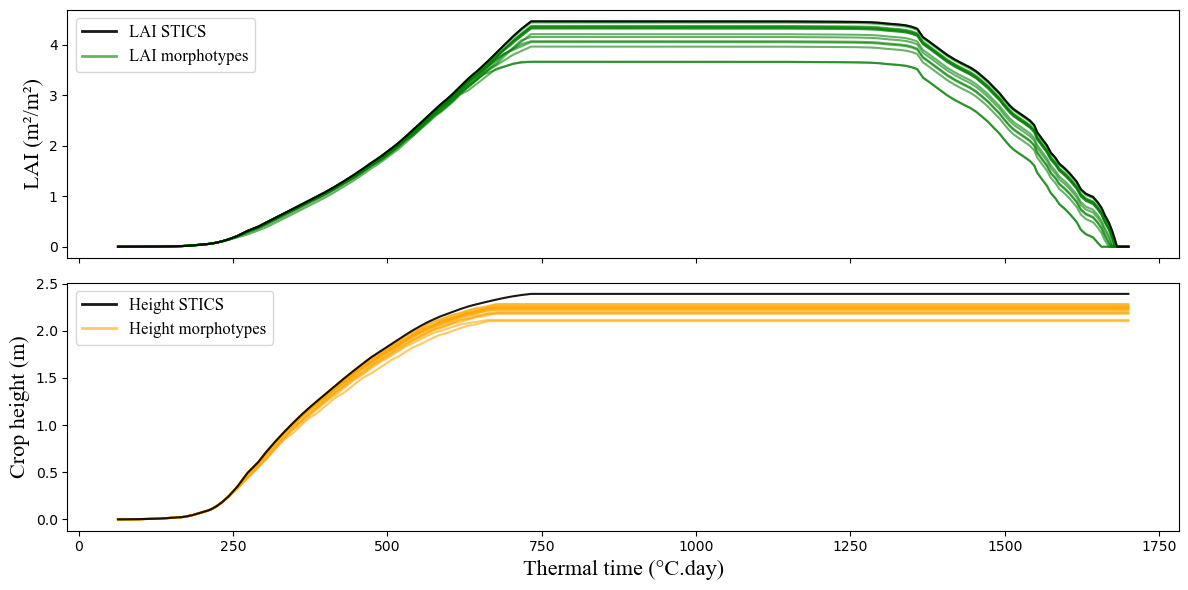

In [53]:
plot_constrainted_vs_realized(thermal_time, LA_archicrop, height_archicrop, leaf_area_plant, sen_leaf_area_plant, height_canopy, sowing_density)


## Light interception

In [34]:
fn = 'climsorj.meteo'
df_weather = stics_weather_3d(filename=fn, daily_dynamics=daily_dynamics)


In [35]:
# faire au zenith aussi !!!!!!!!!!!!!!!!!!!!
# ciel 6 directions, 16, 36...

In [36]:


location ={  
'longitude': 3.87,
'latitude': 45,
'altitude': 56,
'timezone': 'Europe/Paris'}


inter_plant = (100 / inter_row / sowing_density)*100 
domain = ((-0.5*inter_row, -0.5*inter_plant), (0.5*inter_row, 0.5*inter_plant))

start_time = t.time()

par_caribu = []
scenes = []
for mtgs_plant in mtgs:
    scenes_tmp = []
    aggs_tmp = []
    count = 0
    # print(len(mtgs_plant))
    for mtg, par in zip(mtgs_plant, par_incident):
    # for mtg,row in zip(mtgs_plant,df_weather.itertuples()): 
        count += 1
        if count%1==0:
            # irr = sky_irradiance(daydate=row.daydate, day_ghi=row.rad, **location)
            # sun, sky = sky_sources(sky_type='clear_sky', sky_irradiance=irr, scale='global')
            # lights = caribu_light_sources(sun, sky)
            lights = [(par,(0,0,-1))]
            
            scene, labels = build_scene(mtg, (0,0,0), senescence=False)
            cs, raw, agg = illuminate(scene, light=lights, labels=labels, domain=domain, direct=False) # --> cf PARaggregators in caribu scene node
            aggs_tmp.append(agg)
            scenes_tmp.append(cs.plot(raw, display=False)[0])
        # print((t.time() - start_time)/60)
    par_caribu.append(aggs_tmp)
    scenes.append(scenes_tmp)

end_time = t.time()

elapsed_time = (end_time - start_time)/60
print(f"Elapsed time: {elapsed_time:.4f} minutes for {len(mtgs)} simulations")

Elapsed time: 4.8198 minutes for 1 simulations


In [37]:
nrj_per_leaf = []
irr_per_plant = []

for case in par_caribu:
    nrj_tmp = []
    irr_tmp = []
    for df_scene in case:
        df_mod = mean_leaf_irradiance(df_scene)
        nrj_tmp.append(df_scene.loc[df_scene['label'] == 'Leaf']['Energy'].values)
        irr_tmp.append(df_mod['Irradiance'].values[0])
    nrj_per_leaf.append(nrj_tmp)
    irr_per_plant.append(irr_tmp)

In [38]:
nrj_per_plant = [[sum(growing_plant) for growing_plant in plant] for plant in nrj_per_leaf]

In [39]:
# Conversion
# irr_per_plant = [[i*0.0864/4.6  for i in irr] for irr in irr_per_plant]
# irr_per_plant

In [40]:
# Energy in Caribu : W = 0.0864 MJ.day-1
# Irradiance in Caribu : W.m-2 = 0.0864 MJ.m[leaf]-2.day-1
# Incident PAR in STICS : MJ.m[soil]-2.day-1
# Absorbed PAR in STICS : MJ.m[soil]-2.day-1

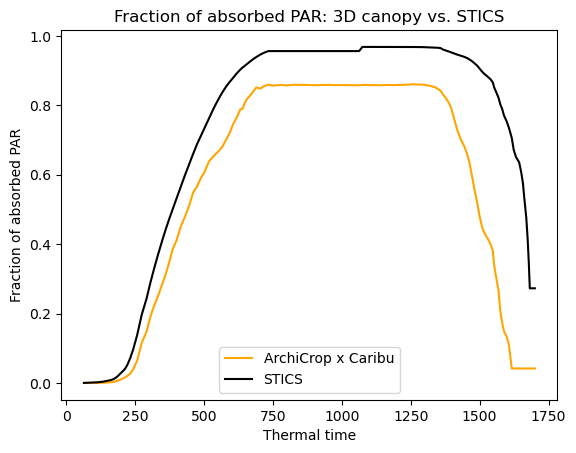

In [ ]:
curves = nrj_per_plant
# curves_array = np.array(curves)

# # Calculate the envelope: min and max values for each time point
# min_values = curves_array.min(axis=0)
# max_values = curves_array.max(axis=0)

# Plotting the envelope along with individual curves for context
time_points = thermal_time
for curve in curves:
    # plt.plot(time_points, [i/sowing_density/0.0864/par for i,par in zip(curve, par_incident)], alpha=0.5, linestyle='--')  # Plot each curve (optional for visualization)
    plt.plot([t for c,t in enumerate(time_points) if c%1==0], [i*sowing_density/par for i,par in zip(curve, [r for c,r in enumerate(par_incident) if c%1==0])], color='orange', label="ArchiCrop x Caribu")

# plt.fill_between(time_points, min_values, max_values, color="skyblue", alpha=0.4)
# plt.plot(time_points, min_values, color="blue", linestyle="--", label="Min 3D")
# plt.plot(time_points, max_values, color="red", linestyle="--", label="Max 3D")
plt.plot(time_points, par_stics, color="black", label="STICS")
# plt.scatter(time_points, LA_stics)

# Labels and legend
plt.xlabel("Thermal time") 
plt.ylabel("Fraction of absorbed PAR")
plt.title("Fraction of absorbed PAR: 3D canopy vs. STICS")
plt.legend()
plt.show()

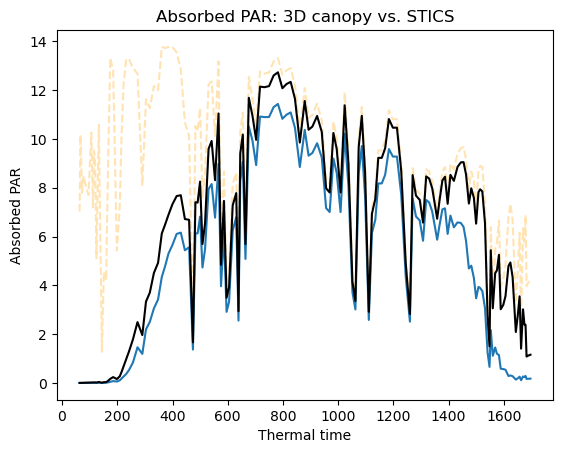

In [60]:
start = 0
end = len(time_points)-1

for curve in curves:
    plt.plot([t for c,t in enumerate(time_points) if c%1==0][start:end], [i*sowing_density for i,par in zip(curve, par_incident)][start:end], alpha=1, linestyle='-')  # Plot each curve (optional for visualization)

plt.plot(time_points[start:end], par_incident[start:end], "--", color="orange", alpha=0.3, label="STICS")
plt.plot(time_points[start:end], [i*par for i,par in zip(par_stics, par_incident)][start:end], color="black", label="STICS")

# plt.plot(thermal_time, raint)

# Labels and legend
plt.xlabel("Thermal time")
plt.ylabel("Absorbed PAR")
plt.title("Absorbed PAR: 3D canopy vs. STICS")
# plt.legend()
plt.show()

In [ ]:
# test direct True and False
# see if sum eabs and esoil = 1
# see tests caribu (cf light vege manager in oa incubator)
# compute memory 
# abscissa = dates instead of thermal time

$$ raint(t)=0.95⋅parsurrgG⋅trg(t)⋅(1−exp(−extinP⋅(lai(t)+eai(t)))) $$

$$ parsurrgG = 0.48 $$

$$ extinP(maize) = 0.7 $$

In [44]:
"""
# vertical light interception
cs, ei, df = illuminate(scene, scene_unit='cm')
cs.plot(ei)


# diffuse light interception
sources = skys.sky_sources()
cs, ei, df = illuminate(scene, light=sources, scene_unit='cm')
cs.plot(ei)

# get score per plant
def score(res):
    return pd.Series({'ei':(res.Ei*res.area).sum() / res.area.sum(),
                              'area': res.area.sum()})
df['nump']=nump
df.groupby('nump').apply(score)
"""

"\n# vertical light interception\ncs, ei, df = illuminate(scene, scene_unit='cm')\ncs.plot(ei)\n\n\n# diffuse light interception\nsources = skys.sky_sources()\ncs, ei, df = illuminate(scene, light=sources, scene_unit='cm')\ncs.plot(ei)\n\n# get score per plant\ndef score(res):\n    return pd.Series({'ei':(res.Ei*res.area).sum() / res.area.sum(),\n                              'area': res.area.sum()})\ndf['nump']=nump\ndf.groupby('nump').apply(score)\n"